In [25]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the graph

In [26]:
# beta should be higher than c
n = 100 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account
c = 1e-3 # numerator
beta = 1 # denominator
threshold = 0.5
sigma = 1.0 # from the normal DEPRECATED
n_iteration = 50
warm_up  = 2 # original 5

################################################

params_dict = {
    "n": n,
    "p": p,
    "c": c,
    "beta": beta,
    "threshold": threshold,
    "sigma": sigma,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [27]:
ut  = utils.GraphUtils()

graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation

In [28]:
g = graphs[-1]
s = spectra[-1]

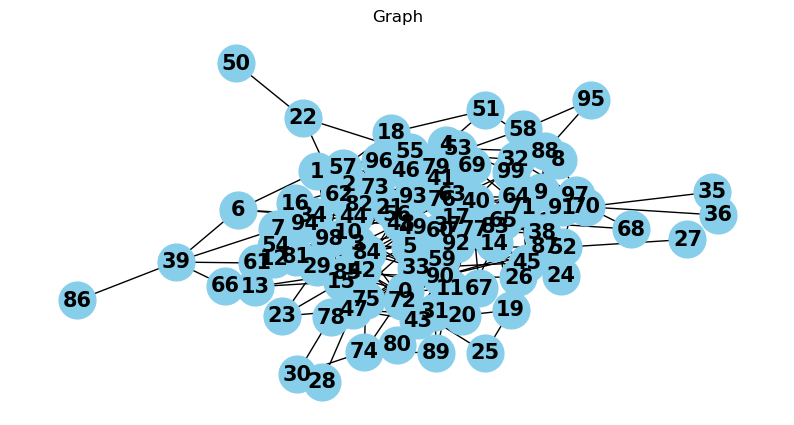

In [29]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

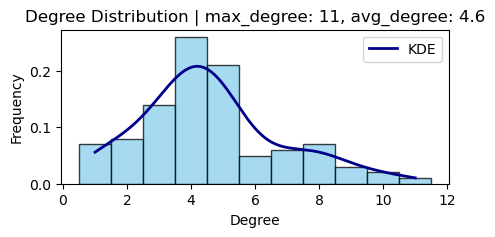

In [30]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [31]:
initial_guess = [1, 1]
est = estimator.LogisticModelEstimator(g)
c1,beta1 = est.estimate_parameters(initial_guess=initial_guess)

Current parameters: c=0.9790370244584012, beta=1.9997802526837796
Current loss: 125.40881460529512

Current parameters: c=0.8483491005401685, beta=2.0761822978124735
Current loss: 122.40268527791547

Current parameters: c=0.1878840037297126, beta=2.0287835637835596
Current loss: 116.05873050739999

Current parameters: c=0.05027985684393791, beta=1.961535395607588
Current loss: 115.9351996722732

Current parameters: c=0.08061982773471733, beta=1.9776603518440752
Current loss: 115.92581356918613

Current parameters: c=0.07865972355606722, beta=1.976092114080559
Current loss: 115.92576246006568

Current parameters: c=0.07791091598802583, beta=1.9726094782700334
Current loss: 115.92573782161784

Current parameters: c=0.07647612748451886, beta=1.9590329233691146
Current loss: 115.92564570882706

Current parameters: c=0.0649615504069588, beta=1.8176883107087558
Current loss: 115.92540617105186

Current parameters: c=0.06826076315876367, beta=1.8338175154021992
Current loss: 115.9249442608794

In [116]:
initial_guess = [1, 1]
est2 = estimator.MLEGraphModelEstimator(g)
c2, beta2, result = est2.estimate_parameters(initial_guess=initial_guess)

Current parameters: c=1.5000000022211937, beta=0.5000049977788286
Current loss: -1641.7586008938467

Current parameters: c=1.500009382546205, beta=0.4999956175476205
Current loss: -1742.0145461864508

Optimization completed. Estimated parameters: c=1.500009382546205, beta=0.4999956175476205


In [117]:
print(c1,beta1)
print(c2,beta2)
print(c,beta)
print(result)

0.023434330334371103 0.0
1.500009382546205 0.4999956175476205
0.001 1
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 10000000000.0
        x: [ 1.500e+00  5.000e-01]
      nit: 2
      jac: [-2.927e+07  2.903e+07]
     nfev: 123
     njev: 41
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [109]:
est2.likelihood_function([c2, beta2]), est2.likelihood_function([c, beta]), est2.likelihood_function([2,0])

(-1334.543986595563, -1271.3680905754281, 10000000000.0)

In [118]:
c_values = np.linspace(0.000001, 2, 10)
beta_values = np.linspace(0.000001, 2, 10)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est2.likelihood_function([ci, betaj])


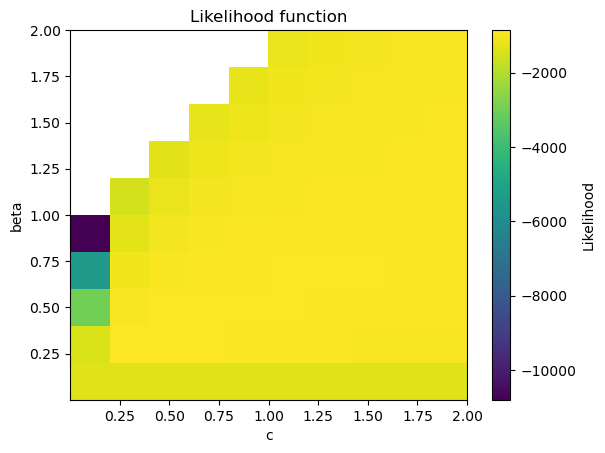

In [121]:
plt.imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
plt.colorbar(label='Likelihood')
plt.xlabel('c')
plt.ylabel('beta')
plt.title('Likelihood function')
plt.show()

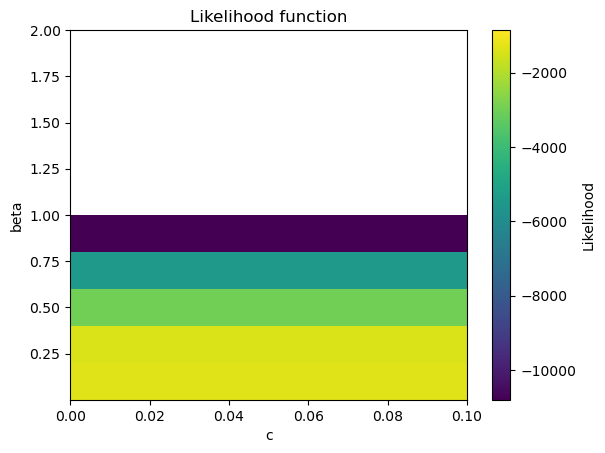

In [122]:
plt.imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
plt.colorbar(label='Likelihood')
plt.xlabel('c')
plt.ylabel('beta')
plt.title('Likelihood function')
plt.xlim(0, 0.1)
plt.show()